In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Scraping GOOGLE Stock

In [ ]:
def scrape_yahoo_finance_data(symbol, start_date, end_date):
    # Download the historical data
    data = yf.download(symbol, start=start_date, end=end_date, period="max")

    # Save the data to a CSV file
    data.to_csv('yahoo_finance_data.csv')

symbol = "GOOGL"
start_date = "2018-01-01"
end_date = "2021-12-31"

scrape_yahoo_finance_data(symbol, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Read data and rename columns according to NeuralProphet
df = pd.read_csv('/content/yahoo_finance_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
1,2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2,2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
3,2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
4,2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1002,2021-12-23,146.500000,148.243500,146.451996,146.916504,146.916504,26384000
1003,2021-12-27,147.255997,148.343994,147.169495,147.906494,147.906494,15976000
1004,2021-12-28,148.235992,148.298996,146.054504,146.686996,146.686996,18200000
1005,2021-12-29,146.644501,147.417007,145.647507,146.654999,146.654999,17788000
1006,2021-12-30,146.694000,147.300003,145.994507,146.200500,146.200500,15688000


# Explorartory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1007 non-null   object 
 1   Open       1007 non-null   float64
 2   High       1007 non-null   float64
 3   Low        1007 non-null   float64
 4   Close      1007 non-null   float64
 5   Adj Close  1007 non-null   float64
 6   Volume     1007 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.2+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1.007000e+03
mean,78.367000,79.156197,77.586732,78.411185,78.411185,3.542798e+07
std,29.137085,29.317458,28.929945,29.148133,29.148133,1.658319e+07
min,49.216000,50.605999,48.882999,49.233501,49.233501,9.312000e+06
25%,57.178751,57.656000,56.569000,57.245750,57.245750,2.470200e+07
50%,64.559998,65.125999,64.018997,64.737000,64.737000,3.119400e+07
75%,88.529251,89.654003,87.816502,88.709251,88.709251,4.038000e+07
max,149.975494,150.966507,148.899002,149.838501,149.838501,1.331780e+08


In [ ]:
df.set_index('Date', inplace= True)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000


In [ ]:
df.isnull().all()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
Month        False
dtype: bool

### Visualization

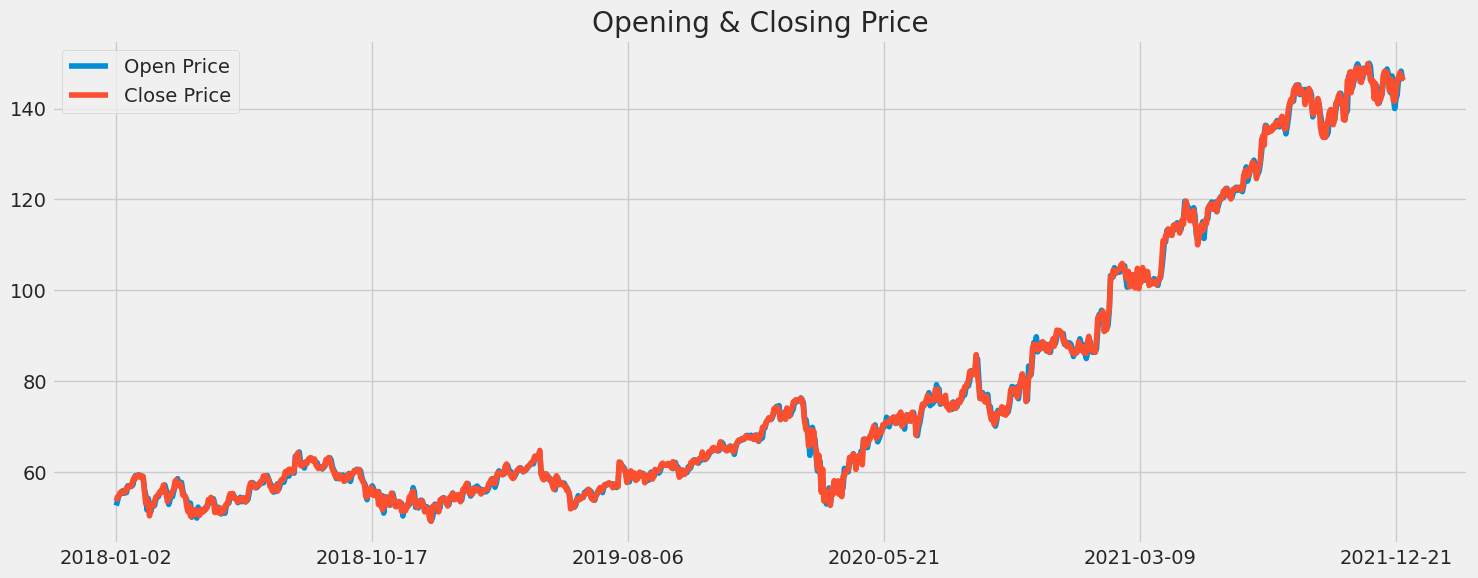

In [ ]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Adj Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

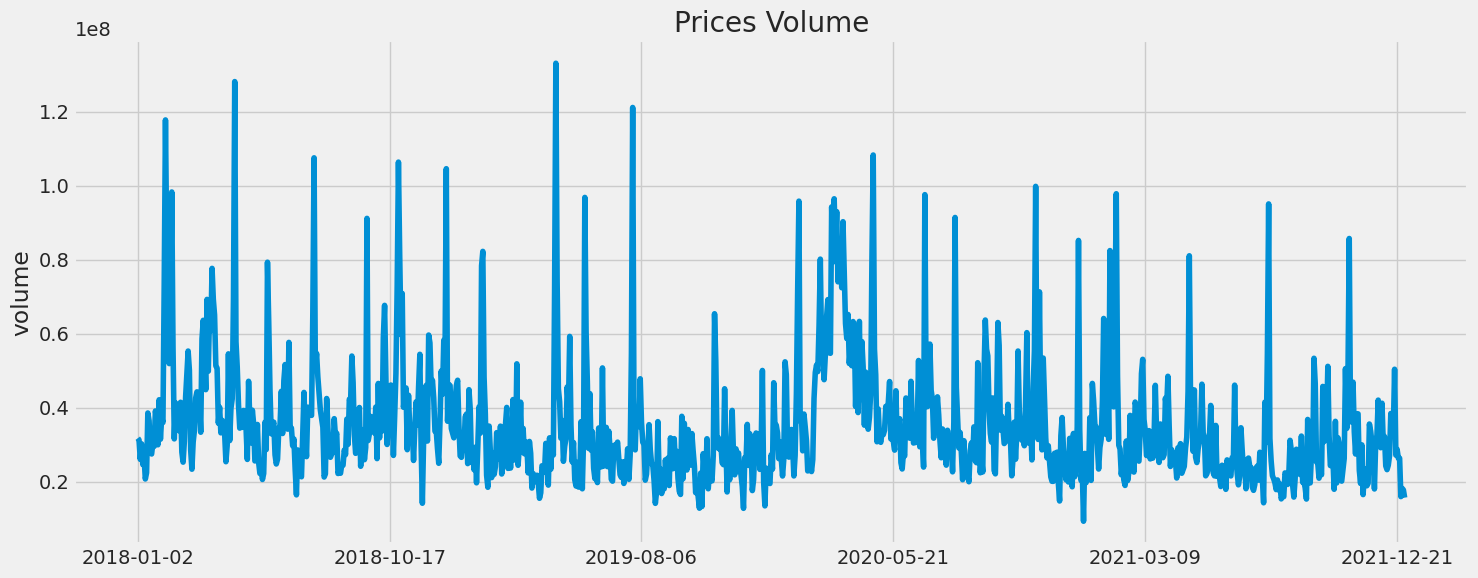

In [ ]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('volume')
plt.xlabel(None)
plt.title("Prices Volume")
plt.tight_layout()
plt.show()

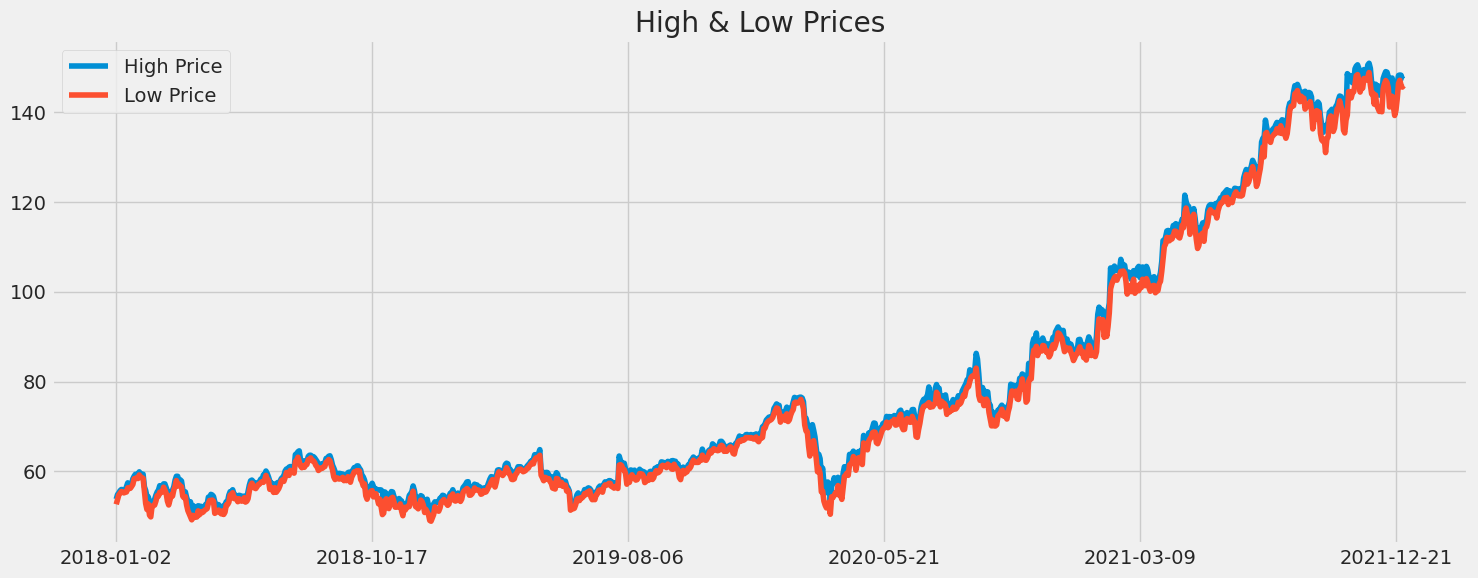

In [ ]:
plt.figure(figsize=(15, 6))
df['High'].plot()
df['Low'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("High & Low Prices")
plt.legend(['High Price', 'Low Price'])
plt.tight_layout()
plt.show()

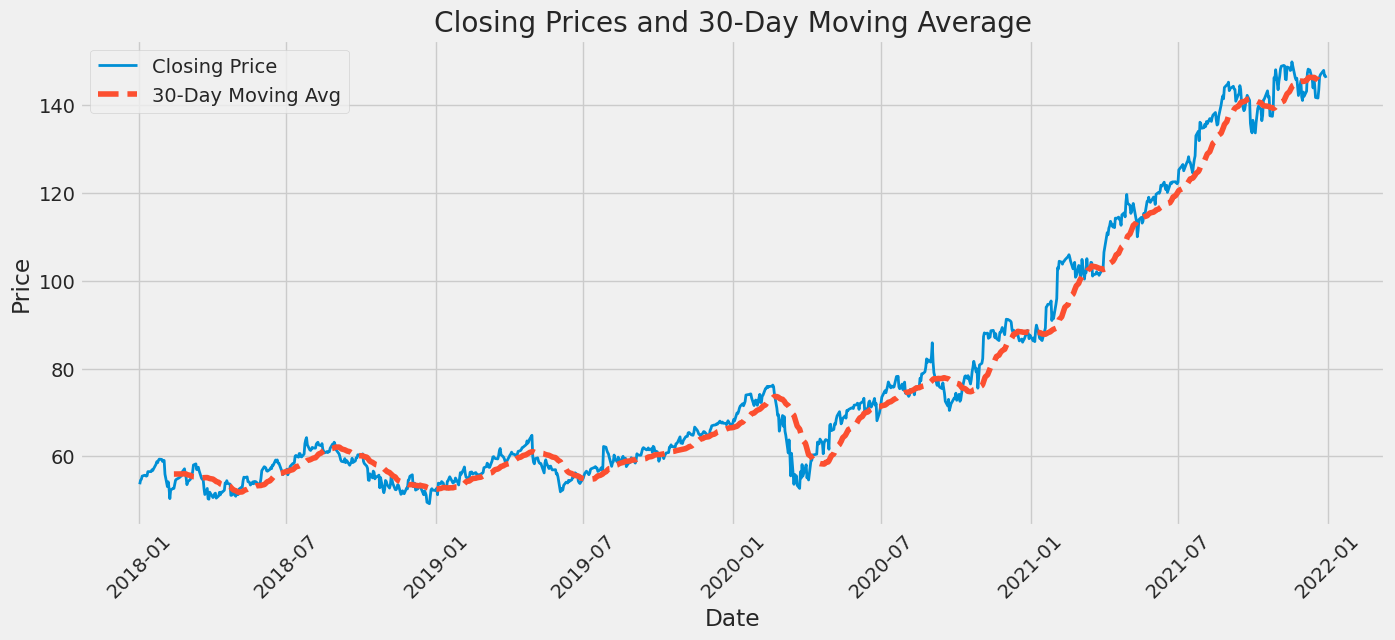

In [ ]:
# Closing Prices and Moving Average plot
df.index = pd.to_datetime(df.index)
window = 30
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Adj Close'], label='Closing Price', linewidth=2)
plt.plot(df.index, df['Adj Close'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

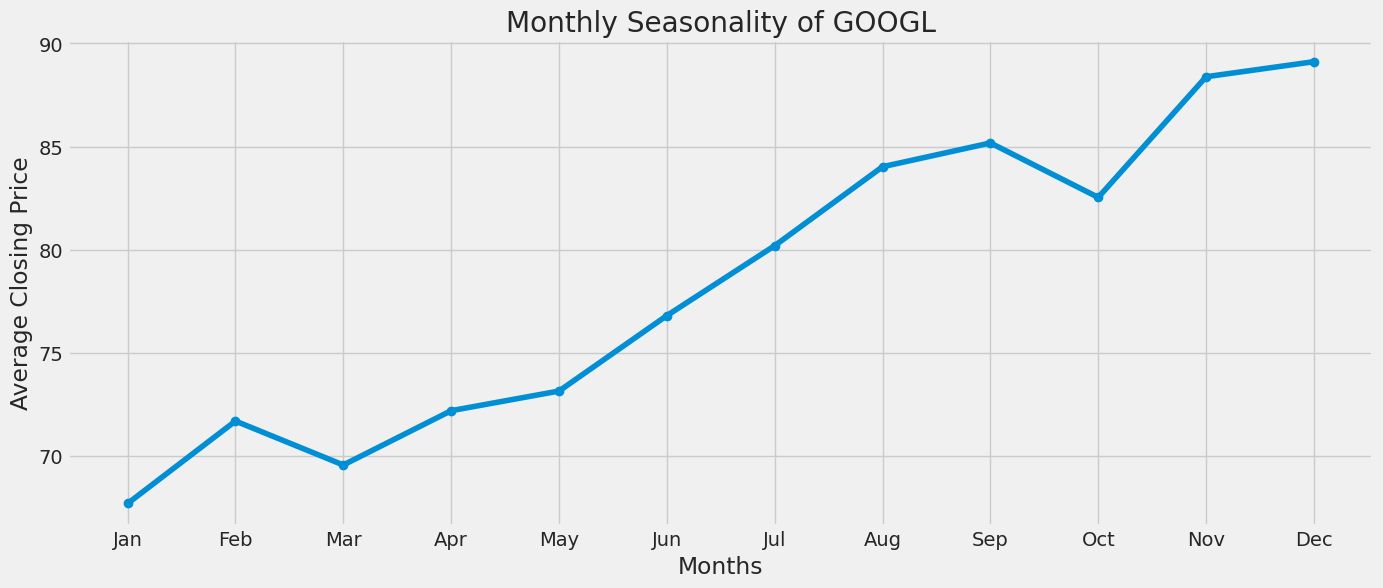

In [ ]:
# Monthly Seasonality of Closing Prices

df.index = pd.to_datetime(df.index)
df['Month'] = df.index.month

monthly_average = df.groupby('Month')['Adj Close'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of GOOGL')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()